# Формирование модели монетизации для игрового приложения

## Материалы
* [Презентация](https://drive.google.com/file/d/15v_XTWN62odIUJk-u_kU4YBGGvX8iU8-/view?usp=sharing)
* [Дашборд](https://public.tableau.com/views/UserBehaviour/GameMonetization?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

## Описание проекта
Разработчики мобильной игры "Космические братья" хотят зарабатывать с помощью рекламы в приложении. Нужно помочь бизнесу выбрать оптимальное время для запуска рекламы и рассчитать окупаемость игры при разных сценариях.

Пока создатели игры планируют показывать рекламу на экране с выбором постройки.

**Задача:** предложить такую модель монетизации с помощью размещения рекламы, чтобы максимизировать прибыль компании и при этом не увеличить отток пользователей.

### Описание данных
Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.
Основная монетизация игры только планируется, но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:
- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников
В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет `game_actions.csv`:
- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях.

Датасет `ad_costs.csv` содержит колонки:
- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет `user_source.csv` содержит колонки:
- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение.

### План работы
1. Подготовить данные к анализу:
    - проверить наличие пропусков и дубликатов,
    - убедиться, что типы данных соответствуют сохранённым в ним значениям.
2. Провести исследовательский анализ данных:
    - составить профили пользователей, содержащие следующую информацию: id пользователя, дата привлечения, источник, сколько зданий построил на первом уровне, перешёл на второй уровень (да/нет), тип игрока (определяется по тому, каким способом игрок перешёл на второй уровень - победой над врагом или завершением исследования),
    - показать на графике из каких источников приходит больше всего пользователей и сколько из них переходят на следующий уровень,
    - посмотреть, есть ли разница в количестве "военных" и "исследователей" в зависимости от источника привлечения,
    - посмотреть, есть ли разница по количеству построек в зависимости от источника привлечения,
    - узнать, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.
    - проанализировать потенциальную окупаемость рекламы с разбивкой по каналам привлечения и по типам игроков. Потенциальные доходы от рекламы нам не известны, поэтому рассчитаем при какой CPM (cost per mille - цена за тысячу показов рекламы) окупятся затраты на привлечение.
3. Проверить статистические гипотезы:
    - Различается ли время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком?
    - Различается ли количество построенных зданий в первый день игры для пользователей, которые перейдут на второй уровень, и пользователей, которые забросят игру?
4. Сделать выводы, описать оптимальную модель монетизации.

## Загрузка и предобработка данных

### Загрузка библиотек и данных

In [3]:
!pip install missingno

In [4]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import matplotlib.patches as mpatches
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats as st

pd.options.mode.chained_assignment = None # уберём предупреждения
pd.set_option('display.float_format', '{:.2f}'.format) # два знака после точки для float

In [5]:
actions = pd.read_csv('https://.../game_actions.csv')
costs = pd.read_csv('https://.../ad_costs.csv')
sources = pd.read_csv('https://.../user_source.csv')

### Функции

In [6]:
def get_profiles(actions, sources, costs):
    '''Функция для создания профилей пользователей, возвращает датафрейм следующего вида:
    ID пользователя, дата привлечения, источник, сколько зданий построил на первом уровне, 
    перешёл на второй уровень (да/нет), тип игрока (researcher или warrior), время с начала игры до перехода на второй уровень,
    время с начала игры до последней активности, стоимость привлечения'''

    # добавим к actions столбец с датой события - это понадобится для расчёта дней, в котоыре пользователь был активен в игре
    actions['event_dt'] = actions['event_datetime'].dt.day
    
    # сортируем сессии по ID пользователя и дате первого посещения
    # группируем по ID и находим первые значения session_start и channel
    # столбец с временем первого посещения назовём first_ts
    # от англ. first timestamp — первая временная отметка
    profiles = (
        actions.sort_values(by=['user_id', 'event_datetime'])
        .groupby('user_id')
        .agg({'event_datetime': 'first', 'event_dt':'nunique', 'building_type': 'count'})
        .rename(columns={'event_datetime': 'first_ts', 'event_dt':'days_active', 'building_type': 'buildings'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # определяем дату первого посещения
    # эти данные понадобятся для когортного анализа
    profiles['dt'] = profiles['first_ts'].dt.date
    
    # найдём игроков, перешедших на второй уровень
    levelup = actions.loc[actions['event']=='finished_stage_1', 'user_id']
    profiles['leveled_up'] = profiles['user_id'].isin(levelup)
    
    # определим типы игроков
    # researcher - если перешёл на следующий уровень и закончил проект
    # warrior - если перешёл на следующий уровень и НЕ закончил проект
    researchers = actions.loc[actions['event']=='project', 'user_id'].unique()
    profiles.loc[(profiles['leveled_up']==True)&(profiles['user_id'].isin(researchers)),'player_type'] = 'researcher'
    profiles.loc[(profiles['leveled_up']==True)&(profiles['user_id'].isin(researchers)==False),'player_type'] = 'warrior'
    
    # рассчитаем время с начала игры до перехода на второй уровень в днях
    levelup_time = actions.loc[actions['event']=='finished_stage_1',['event_datetime', 'user_id']]
    profiles = profiles.merge(levelup_time, on='user_id', how='left').rename(columns={'event_datetime':'levelup_ts'})
    profiles['levelup_time'] = profiles['levelup_ts'].dt.date - profiles['dt']
    profiles.loc[profiles['levelup_time'].isna()==False, 'levelup_time'] = (profiles.loc[profiles['levelup_time']
                                                                                        .isna()==False, 'levelup_time']
                                                                            .apply(lambda x: x/np.timedelta64(1,'D')))
    
    # подтянем каналы привлечения из таблицы sources
    profiles = profiles.merge(sources, on='user_id')
    
    # преобразуем тип столбца с датой для дальнейшего объёдинения и расчёта САС
    profiles['dt'] = profiles['dt'].astype('datetime64[ns]')
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'source'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    costs = costs.merge(new_users, on=['dt', 'source'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    costs['acquisition_cost'] = costs['cost'] / costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'source', 'acquisition_cost']],
        on=['dt', 'source'],
        how='left',
    )

    return profiles 

In [7]:
# Зададим цвета для категорий, чтобы они одинаково отображались на всех графиках
current_palette ={"researcher": "#0984e3",
                "warrior": "#d63031",
                "facebook_ads": "#0984e3",
                "instagram_new_adverts": "#fdcb6e",
                "yandex_direct": "#00b894",
                "youtube_channel_reklama":"#d63031",
               True: "#ff7675",
               False: "#b2bec3"}

In [8]:
def draw_count_bars(source, groupers, title):
    '''Функция рисует столбчатую диаграмму количества пользователей 
    с двумя уровнями группировки и подписями долей в процентах'''
    # сгруппируем данные
    agg_df = source.groupby(groupers).size().unstack().fillna(0)
    # рассчитаем проценты для подписей данных
    percentages = agg_df.div(agg_df.sum(axis=1), axis=0).mul(100).round(2)
    
    # нарисуем график
    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    bottom = np.zeros(len(agg_df))

    for i, col in enumerate(agg_df.columns):
        ax.bar(agg_df.index, agg_df[col], bottom=bottom, label=col, color=current_palette[col])
        bottom += np.array(agg_df[col])

    # добавим метки данных
    # счётчики номера столбца и ряда для меток данных
    col_idx = 0
    row_idx = 0
    l = len(agg_df)

    # iterate through each bar patch from ax
    for i, p in enumerate(ax.patches, 1):

        left, bottom, width, height = p.get_bbox().bounds
        v = percentages.iloc[row_idx, col_idx]
        if width > 0:
            ax.annotate(f'{v:.2f}%', xy=(left+width/2, bottom+height/2), ha='center', va='center')

        row_idx += 1
        if i%l == 0:  # обновить счётчики после последнего столбца 
            col_idx += 1
            row_idx = 0

    ax.set_title(title, fontsize=18)
    ax.set(xlabel=groupers[0], ylabel='Users')
    ax.legend(title=groupers[1], bbox_to_anchor=(1, 1.02), loc='upper left')

    plt.grid(False)
    ax.yaxis.grid()
    plt.show();

In [9]:
def draw_mean_bars(source, grouper, values, title):
    '''Функция рисует столбчатую диаграмму средних значений по группам 
    и подписывает средние значения на столбиках'''
    # сгруппируем данные
    df = source.groupby(grouper).mean().reset_index()

    # нарисуем график
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(10, 6))

    ax = sns.barplot(
        x=grouper, 
        y=values, 
        data=df,
        palette=current_palette)

    ax.set_title(title,fontsize=18)

    for i, v in enumerate(round(df[values],2)):
        ax.text(i, v/6*5, str(v), ha='center', color='white')
    plt.show();

### Предварительная обработка
Проверим, есть ли в данных дубликаты.

In [10]:
actions.loc[actions.duplicated()==True]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


In [11]:
costs.loc[costs.duplicated()==True]

,source,day,cost


In [12]:
sources.loc[sources.duplicated()==True]

,user_id,source


Есть один дубликат в таблице `actions`, удалим его.

In [13]:
actions = actions.drop_duplicates()
actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135639 non-null  object
 1   event           135639 non-null  object
 2   building_type   127956 non-null  object
 3   user_id         135639 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 6.2+ MB


Теперь проверим пропуски.

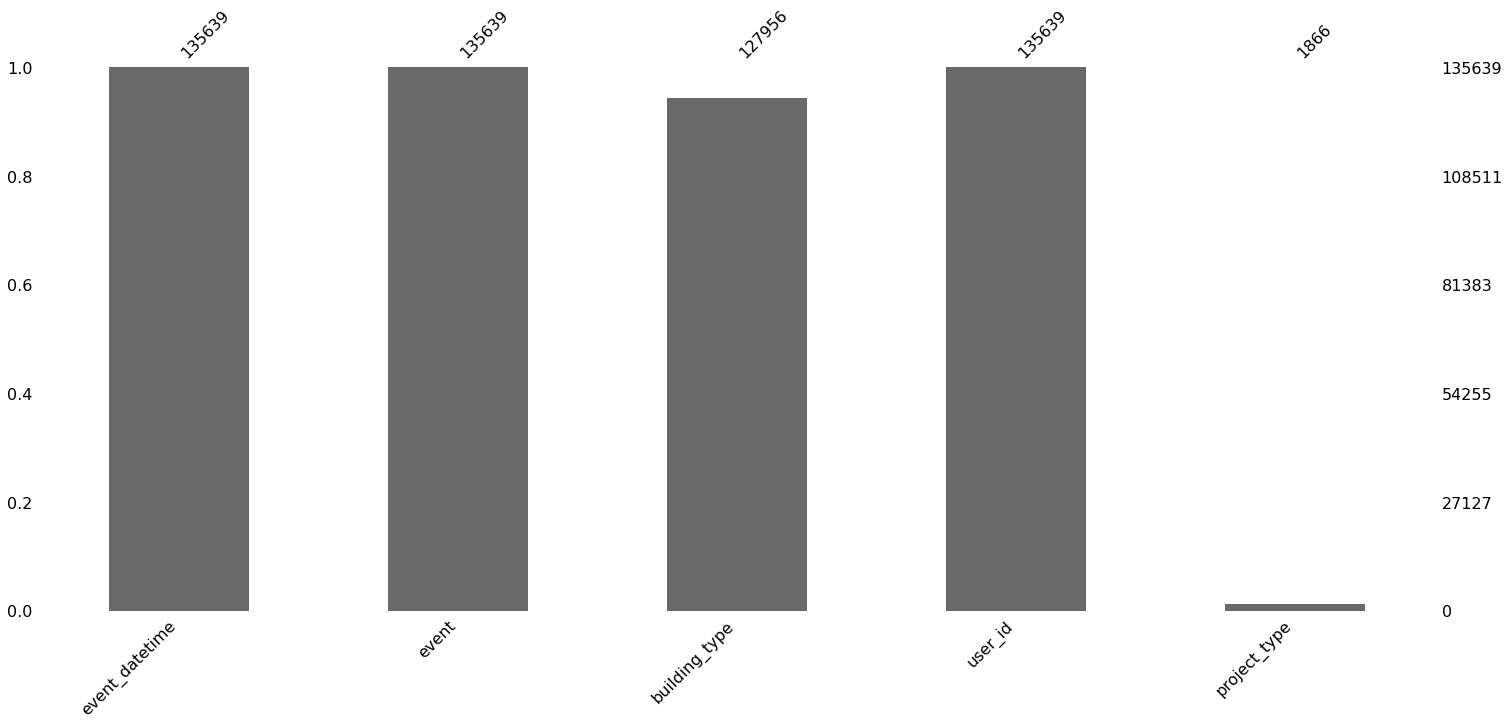

In [14]:
msno.bar(actions);

In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [16]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


Проверим с чем связаны пропуски в столбцах `building_type` и `project_type` в таблице `action`.

In [17]:
actions.loc[actions['building_type'].isna()==True, 'event'].unique()

array(['finished_stage_1', 'project'], dtype=object)

In [18]:
actions.loc[actions['building_type'].isna()==False, 'event'].unique()

array(['building'], dtype=object)

Тип постройки заполнен только для событий типа *building* и оставлен пустым для всех остальных событий. Здесь нет ошибки, оставим пропуски как есть.

In [19]:
actions.loc[actions['project_type'].isna()==True, 'event'].unique()

array(['building', 'finished_stage_1'], dtype=object)

In [20]:
actions.loc[actions['project_type'].isna()==False, 'event'].unique()

array(['project'], dtype=object)

Тип проекта заполнен только для событий типа *project* и оставлен пустым для всех остальных событий. Здесь тоже нет ошибки, однако посмотрим какие значения принимает название проекта.

In [21]:
actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

Поскольку в датасете представлены данные об активностях игроков только на первом уровне, им доступен только один проект. В столбце `project_type` нет полезных для анализа данных, его можно удалить.

In [22]:
actions = actions.drop(columns={'project_type'})
actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135639 non-null  object
 1   event           135639 non-null  object
 2   building_type   127956 non-null  object
 3   user_id         135639 non-null  object
dtypes: object(4)
memory usage: 5.2+ MB


Теперь посмотрим на типы данных.

In [23]:
costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77


In [24]:
actions.head()

,event_datetime,event,building_type,user_id
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d


Столбец `day` в таблице `costs` и столбец `event_datetime` в таблице `actions` нужно привести к формату даты. Ещё добавим в `actions` столбец с датой (понадобится потом для расчёта количества построек в первый день игры).

In [25]:
costs['day'] = pd.to_datetime(costs['day'], format='%Y-%m-%d')
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'], format='%Y-%m-%d %H:%M:%S')
actions['event_day'] = actions['event_datetime'].dt.date.astype('datetime64[ns]')
display(costs.info())
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   event_day       135639 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 6.2+ MB


Для удобства объединения таблиц переименуем *day* в *dt* в таблице `costs`:

In [26]:
costs = costs.rename(columns={'day':'dt'})

В таблице `costs` указываются даты оплаты, а реклама показывалась на следующий день. Для корректного расчёта САС сдвинем даты в `costs` на один день.

In [27]:
costs['dt'] = costs['dt'] + pd.Timedelta('1 day')
costs.head()

,source,dt,cost
0,facebook_ads,2020-05-04,935.88
1,facebook_ads,2020-05-05,548.35
2,facebook_ads,2020-05-06,260.19
3,facebook_ads,2020-05-07,177.98
4,facebook_ads,2020-05-08,111.77


Столбцы `event` и `building_type` преобразуем в тип *Categorical*.

In [28]:
actions = actions.astype({'event':'category', 'building_type':'category'})
actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  category      
 2   building_type   127956 non-null  category      
 3   user_id         135639 non-null  object        
 4   event_day       135639 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](2), object(1)
memory usage: 4.4+ MB


Теперь данные занимают на треть меньше места в памяти.

**Вывод:** Данные очищены от дубликатов и лишних столбцов. Столбцы с датой и временем приведены к формату `datetime`, столбцы `event` и `building_type` - к типу `category`.

## Исследовательский анализ данных

### Профили пользователей
Сформируем профили пользователей с помощью функции `get_profiles`.

In [29]:
profiles = get_profiles(actions, sources, costs)
profiles.head()

,user_id,first_ts,days_active,buildings,dt,leveled_up,player_type,levelup_ts,levelup_time,source,acquisition_cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,8,13,2020-05-06,False,NaN,NaT,NaT,facebook_ads,0.75
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,6,9,2020-05-06,False,NaN,NaT,NaT,yandex_direct,0.46
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,3,4,2020-05-05,False,NaN,NaT,NaT,youtube_channel_reklama,0.39
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,6,8,2020-05-05,True,warrior,2020-05-12 07:40:47,7.00,instagram_new_adverts,0.63
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,9,12,2020-05-05,False,NaN,NaT,NaT,facebook_ads,0.79


### Откуда приходят пользователи
Покажем на графике из каких источников приходит больше всего пользователей и сколько из них переходит на следующий уровень.

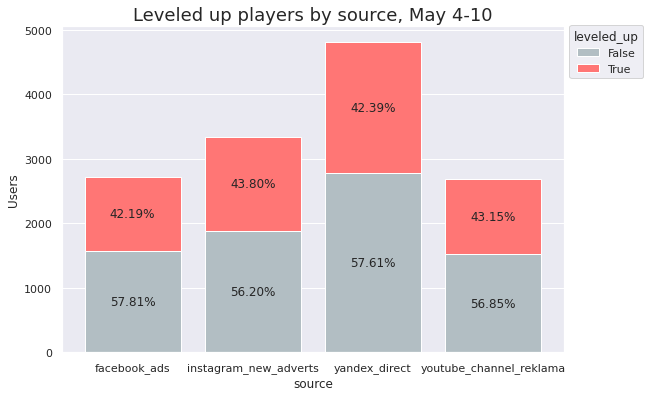

In [30]:
draw_count_bars(profiles, ['source', 'leveled_up'], 'Leveled up players by source, May 4-10')

Больше всего пользователей пришло из Яндекс.Директ. Доля игроков, дошедших до второго уровня, от канала привлечения не зависит.

### Типы пользователей по источнику привлечения
Покажем на графике откуда приходит больше "исследователей". Предполагается, что "исследователи" чаще заходят на экран выбора постройки, поэтому нам важно привлечь больше таких игроков.

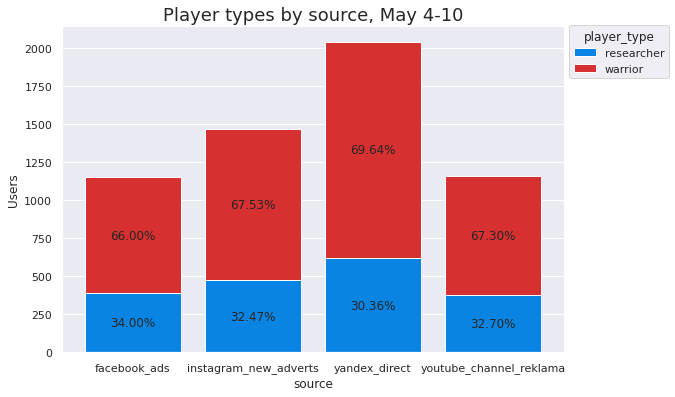

In [31]:
draw_count_bars(profiles, ['source', 'player_type'], 'Player types by source, May 4-10')

Чуть больше "исследователей" приходит из Фейсбука и чуть меньше из Яндекс.Директа, но разница не выглядит существенной.

### Среднее количество построек на игрока
Проверим, зависит ли количество построек от типа игрока и канала привлечения.

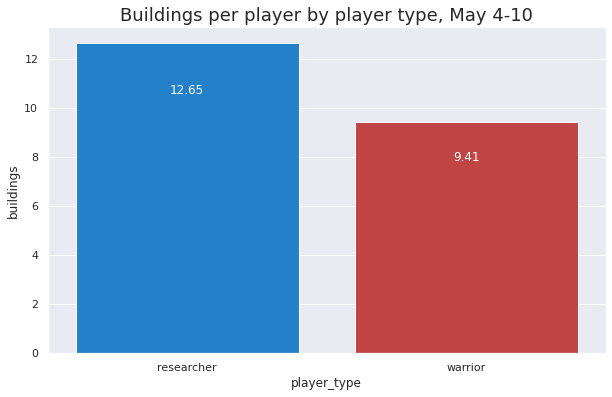

In [32]:
draw_mean_bars(profiles, 'player_type', 'buildings', "Buildings per player by player type, May 4-10")

"Исследователи" строят заметно больше.

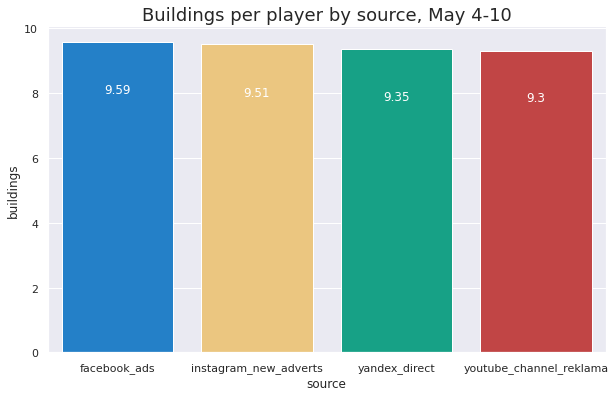

In [33]:
draw_mean_bars(profiles, 'source', 'buildings', "Buildings per player by source, May 4-10")

От источника привлечения количество построек не зависит, а вот стиль игры явно влияет на этот показатель.

### Стоимость привлечения пользователей для разных источников
Посмотрим как различается стоимость привлечения в разных каналах:

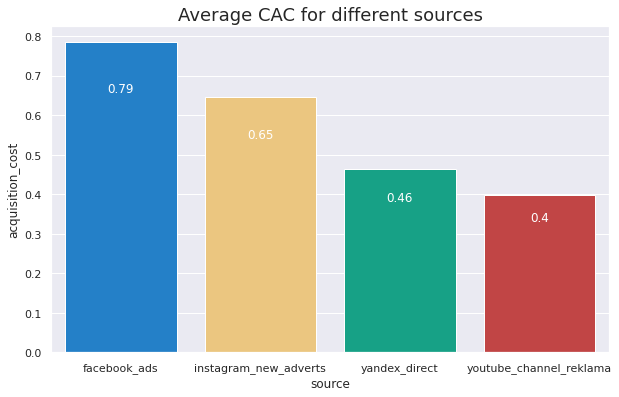

In [34]:
draw_mean_bars(profiles, 'source', 'acquisition_cost', "Average CAC for different sources")

Самые "дорогие" клиенты приходят из Фейсбука и Инстаграма, самые "дешёвые" - из YouTube. Проверим на сколько этот показатель стабилен, не было ли в нём сильных колебаний:

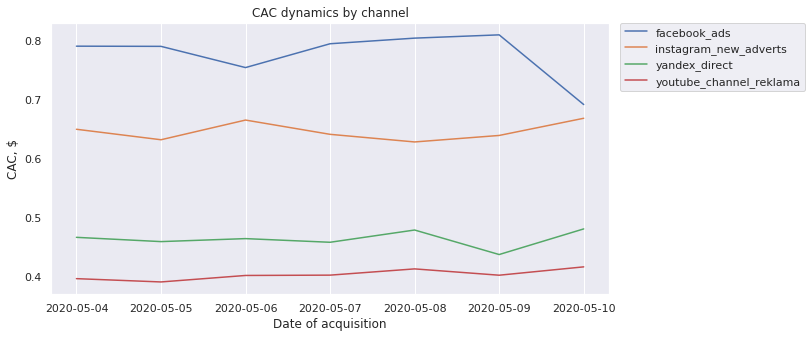

In [35]:
df = profiles.pivot_table(index='dt', columns='source', values='acquisition_cost', aggfunc='mean')

# строим график истории изменений CAC по каналам привлечения
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df)
ax.legend(df.columns, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Date of acquisition')
plt.ylabel('CAC, $')
plt.title('САС dynamics by channel')
plt.grid(axis='y');

plt.show()

В последний день - 10 мая - снизилась стоимость привлечения на Фейсбуке. Возможно, там былка какая-то очень удачная реклама? Посмотрим, как менялось количество привлечённых пользователей по дням.

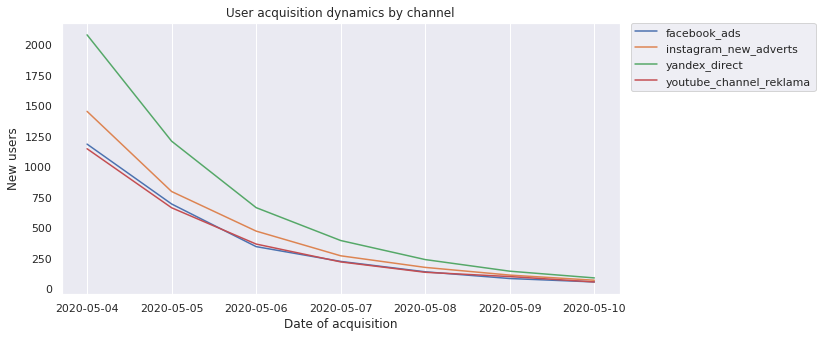

In [36]:
df = profiles.pivot_table(index='dt', columns='source', values='user_id', aggfunc='count')

# строим график истории изменений CAC по каналам привлечения
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df)
ax.legend(df.columns, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Date of acquisition')
plt.ylabel('New users')
plt.title('User acquisition dynamics by channel')
plt.grid(axis='y');

plt.show()

Посмотрим поближе на период с 8 по 10 мая:

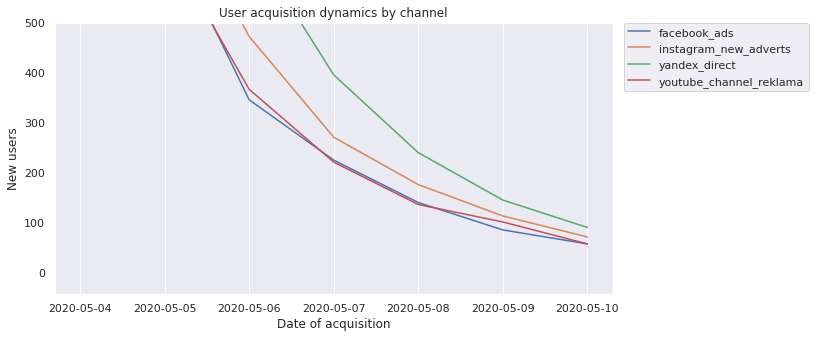

In [37]:
df = profiles.pivot_table(index='dt', columns='source', values='user_id', aggfunc='count')

# строим график истории изменений CAC по каналам привлечения
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df)
ax.legend(df.columns, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Date of acquisition')
plt.ylabel('New users')
plt.title('User acquisition dynamics by channel')
plt.grid(axis='y');
ax.set_ylim(top=500)

plt.show()

Видим, что количество привлекаемых пользователей резко снижается, при этом рейтинг каналов практически не меняется: больше всего приходят из Яндекс.Директ, на втором месте Инстаграм, потом YouTube и Фейсбук примерно на одном уровне.

Можно порекомендовать разработчикам игры оптимизировать расходы на рекламу, чтобы быстрее выйти на окупаемость:
- снизить количество рекламы в Фейсбуке и Инстаграме, 
- увеличить количество рекламы в Яндекс.Директ,
- рекламу в YouTube оставить без изменений.

### Потенциальная окупаемость рекламы по каналам привлечения и по типам игроков
Реклама окупится, если сумма, которую разработчики заработают на показе рекламы в игре, будет равна затратам на приобретение рекламы для привлечения пользователей. Допустим, что вся реклама, затраченная на привлечение пользователей, должна окупиться, пока игрок проходит первый уровень. Если планируется показывать рекламу на странице выбора постройки, то для расчёта целевого CPM для каждого канала нужно поделить расходы на количество построек на первом уровне у пользователей, пришедших из этого канала, и умножить на 1000.

In [38]:
# общие затраты с 4 по 10 мая
total_costs = costs.groupby('source')['cost'].sum() 

# всего построек на первом уровне для игроков, привлечённых 4-10 мая
total_buildings = profiles.groupby('source')['buildings'].sum()

cpm = (total_costs.div(total_buildings) * 1000).reset_index().rename(columns={0:'cpm'})
cpm

,source,cpm
0,facebook_ads,81.93
1,instagram_new_adverts,67.94
2,yandex_direct,49.59
3,youtube_channel_reklama,42.76


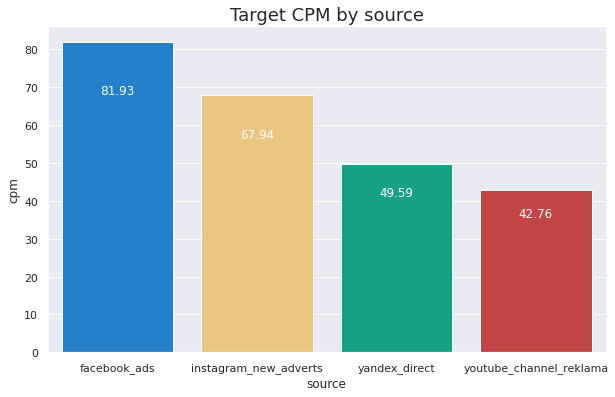

In [39]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x="source", 
    y="cpm", 
    data=cpm,
    palette=current_palette)

ax.set_title('Target CPM by source',fontsize=18)

for i, v in enumerate(round(cpm['cpm'],2)):
    ax.text(i, v/6*5, str(v), ha='center', color='white')
plt.show();

CPM в 40-80 долларов выглядит нереалистично. По информации из [открытых источников](https://www.businessofapps.com/ads/research/mobile-app-advertising-cpm-rates/) даже на рынках Северной Америки и Японии СРМ не превышает 10-15 долларов. Чтобы выйти на окупаемость, нужно показывать игрокам больше рекламы. 

Имеющихся данных недостаточно, чтобы предложить конкретные "точки" показа рекламы, но можно рассчитать, сколько раз в день пользователи должны смотреть рекламу, чтобы отбить затраты на их привлечение. Для этого разделим затраты на потенциальную выручку с продажи одного объявления и на количество дней, которые пользователи из этого канала заходили в игру.

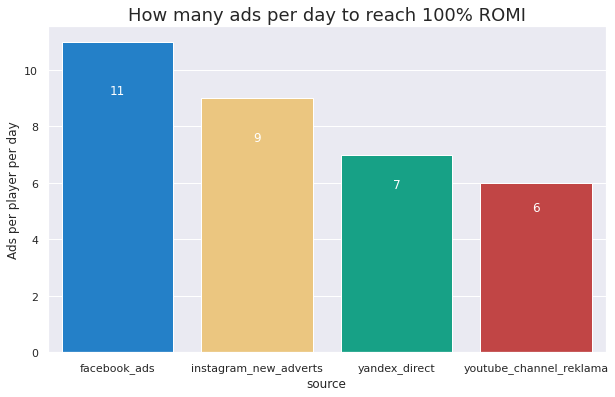

In [40]:
ads_daily = (round(costs.groupby('source')['cost'].sum().div(profiles.groupby('source')['days_active'].sum() * 10 / 1000))
             .reset_index()
             .rename(columns={0:'Ads per player per day'}))

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x="source", 
    y="Ads per player per day", 
    data=ads_daily,
    palette=current_palette)

ax.set_title('How many ads per day to reach 100% ROMI',fontsize=18)

for i, v in enumerate(ads_daily['Ads per player per day']):
    ax.text(i, v/6*5, str(round(v)), ha='center', color='white')
plt.show();

Даже для каналов с низкой стоимостью привлечения (Яндекс и YouTube) для окупаемости нужно показывать рекламу 6-7 раз в день. Чтобы реклама не вызывала раздражения у игроков, можно предложить им внутриигровой бонус за её просмотр (например, ускорение времени постройки или исследования, дополнительные попытки в сражениях). Дополнительные точки для размещения рекламы можно поискать в механике сражений.

## Проверка гипотез
### Различается ли время прохождения уровня между игроками разных типов
Посмотрим, какая стратегия более выгодна игрокам, то есть позволяет быстрее проходить уровни. Если у одной из стратегий (исследование или победа в сражении) есть значительное преимущество, то игра в целом будет более привлекательна для игроков этого типа.

Для "исследователей" среднее время до перехода на второй уровень:

In [41]:
f"{round(profiles.loc[(profiles['player_type']=='researcher')&(profiles['leveled_up']==True), 'levelup_time'].mean())} дней"

'13 дней'

Для "воинов" это будет:

In [42]:
f"{round(profiles.loc[(profiles['player_type']=='warrior')&(profiles['leveled_up']==True), 'levelup_time'].mean())} дней"

'11 дней'

Два дня разницы. Трудно сказать значимо это различие или нет, нужна дополнительная проверка с помощью статистических методов.

Сформулируем нулевую и альтернативную гипотезы и зададим пороговое значение *alpha*:
```
H_0: Среднее время, требующееся для перехода на второй уровень (levelup_time) для игроков типа researcher = Среднее время, требующееся для перехода на второй уровень (levelup_time) для игроков типа warrior`
H_a: Среднее время, требующееся для перехода на второй уровень (levelup_time) для игроков типа researcher ≠ Среднее время, требующееся для перехода на второй уровень (levelup_time) для игроков типа warrior`
alpha = 0.05
```

*Нулевая гипотеза* выражает предположение, что различия между средними значениями двух совокупностей имеют случайный характер. *Альтернативная гипотеза* предполагает, что между средними значениями двух совокупностей есть достоверные различия.

Чтобы определиться с критерием для тестирования гипотез, посмотрим, как распределяются значения в выборках:

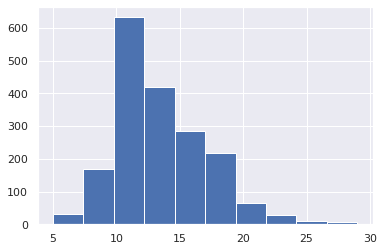

In [43]:
# распределение значений для "исследователей"
profiles.loc[profiles['player_type']=='researcher', 'levelup_time'].hist();

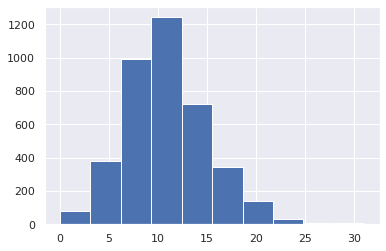

In [44]:
# распределение значений для "воинов"
profiles.loc[profiles['player_type']=='warrior', 'levelup_time'].hist();

Распределение данных "исследователей" явно скошено вправо, у "воинов" распределение тоже не совсем нормальное. Выборки при этом независимые (время, за которое один игрок достигает второго уровня, не зависит от того, за какое время это сделает другой игрок). Для проверки гипотез используем u-критерий Манна-Уитни.

In [45]:
researchers = profiles.loc[profiles['player_type']=='researcher', 'levelup_time'].astype('int')
warriors = profiles.loc[profiles['player_type']=='warrior', 'levelup_time'].astype('int')

alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(researchers, warriors)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  4.7866103584542195e-105
Отвергаем нулевую гипотезу: разница статистически значима


"Исследователи" действительно в среднем дольше идут до второго уровня.

### Различается ли количество построенных зданий в первый день игры для удержанных и потерянных пользователей

Сначала добавим в датафрейм `profiles` зданий построил каждый пользователь в первый день.

In [46]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  category      
 2   building_type   127956 non-null  category      
 3   user_id         135639 non-null  object        
 4   event_day       135639 non-null  datetime64[ns]
 5   event_dt        135639 non-null  int64         
dtypes: category(2), datetime64[ns](2), int64(1), object(1)
memory usage: 5.4+ MB


In [47]:
# рассчитаем сколько построек было у каждого игрока в каждый день активности
buildings = (actions.loc[actions['event']=='building']
             .sort_values(['user_id','event_datetime'])
             .groupby(['user_id','event_day'])['event']
             .count()
             .reset_index().rename(columns={'event':'buildings_daily', 'event_day':'dt'}))
buildings['dt'] = buildings['dt'].astype('datetime64[ns]')
buildings.head()

,user_id,dt,buildings_daily
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,3
1,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-09,3
2,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-11,1
3,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-12,2
4,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-14,1


In [48]:
# теперь подтянем количество построек только для первого дня в profiles
profiles = profiles.merge(buildings, on=['user_id','dt'], how='left')
profiles.head()

,user_id,first_ts,days_active,buildings,dt,leveled_up,player_type,levelup_ts,levelup_time,source,acquisition_cost,buildings_daily
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,8,13,2020-05-06,False,NaN,NaT,NaT,facebook_ads,0.75,3
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,6,9,2020-05-06,False,NaN,NaT,NaT,yandex_direct,0.46,2
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,3,4,2020-05-05,False,NaN,NaT,NaT,youtube_channel_reklama,0.39,2
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,6,8,2020-05-05,True,warrior,2020-05-12 07:40:47,7.00,instagram_new_adverts,0.63,1
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,9,12,2020-05-05,False,NaN,NaT,NaT,facebook_ads,0.79,1


Теперь можно посчитать среднее количество построек в первый день для тех, кто дошёл до второго уровня, и тех, кто забросил игру.

In [49]:
f"{round(profiles.loc[profiles['leveled_up']==True, 'buildings_daily'].mean(), 2)} - для игроков, перешедших на второй уровень"

'1.42 - для игроков, перешедших на второй уровень'

In [50]:
f"{round(profiles.loc[profiles['leveled_up']==False, 'buildings_daily'].mean(), 2)} - для игроков, забросивших игру"

'1.36 - для игроков, забросивших игру'

Разница в 0,06 здания вроде и небольшая, но вдруг этот показатель в будущем поможет разработчикам прогнозировать поведение игроков на раннем этапе? Для этого нужно проверить значимость этой разницы.

Сформулируем нулевую и альтернативную гипотезы и зададим пороговое значение *alpha*:
```
H_0: Среднее количество зданий (buildings_daily), построенных игроками, оставшимися в игре (leveled_up==True), в первый день игры = Среднее количество зданий (buildings_daily), построенных игроками, забросившими игру (leveled_up==False), в первый день игры`
H_a: Среднее количество зданий (buildings_daily), построенных игроками, оставшимися в игре (leveled_up==True), в первый день игры ≠ Среднее количество зданий (buildings_daily), построенных игроками, забросившими игру (leveled_up==False), в первый день игры`
alpha = 0.05
```

Теперь посмотрим, как распределяются значения в выборках:

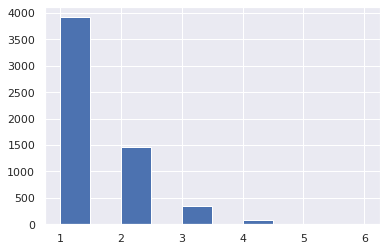

In [51]:
retained = profiles.loc[profiles['leveled_up']==True, 'buildings_daily']
retained.hist();

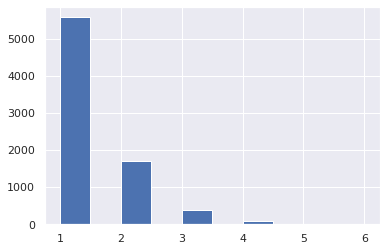

In [52]:
lost = profiles.loc[profiles['leveled_up']==False, 'buildings_daily']
lost.hist();

В обеих выборках данные распределены ненормально, при этом выборки независимые. Для проверки гипотез используем u-критерий Манна-Уитни.

In [53]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(retained, lost)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  2.7958787371801503e-08
Отвергаем нулевую гипотезу: разница статистически значима


Получается, что по количеству построек в первый день игры можно заранее предположить, продолжит пользователь играть или нет.

## Выводы и рекомендации
Вот что можно сказать о поведении пользователей и затратах на их привлечение на основе данных пользователей, пришедших с 4 по 10 мая:
- Больше всего пользователей пришло из Яндекс.Директ. 
- 43% игроков переходят на второй уровень. Это значение одинаково для всех каналов привлечения.
- 68% игроков переходят на второй уровень с помощью победы над другим игроком, 32% - с помощью завершения проекта.
- "Воины" в среднем переходят на второй уровень за 11 дней, а "исследователи" - за 13 дней.
- На первом уровне "исследователи" строят в среднем 12,65 построек, а "воины" - 9,41.
- Игрок, построивший за первый день игры больше одной постройки, с большей вероятностью перейдёт на второй уровень, чем игрок, построивший в первый день игры только одну постройку.
- От источника привлечения количество построек не зависит.
- Самые "дорогие" клиенты приходят из Фейсбука (САС 0,79) и Инстаграма, самые "дешёвые" - из YouTube (САС 0,40), при этом пользователей из этих каналов приходит поровну.

**Модель монетизации:**

С предложенной моделью монетизации (показывать рекламу на странице выбора постройки) приложению, чтобы выйти на окупаемость маркетинговых затрат на первом уровне игроков, нужно зарабатывать от 43 до 82 долларов за тысячу просмотров рекламы в зависимости от канала привлечения. Такие расценки выглядят нереалистичными. 

**Рекомендации:**

1. Оптимизировать расходы на привлечение пользователей: 
    - снизить количество рекламы в Фейсбуке и Инстаграме, 
    - увеличить количество рекламы в Яндекс.Директ и YouTube;
2. Пересмотреть модель монетизации:
    - Найти дополнительные точки размещения рекламы в механике сражений,
    - Исходить из того, что каждый игрок должен увидеть рекламу не менее 6-7 раз в день,
    - Чтобы реклама не вызывала раздражения у игроков, можно предложить им внутриигровой бонус за её просмотр (например, ускорение времени постройки или исследования, дополнительные попытки в сражениях).